In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import os
import json

from skimage.util import montage
from skimage.morphology import label
import tensorflow as tf


In [34]:
paths = json.load(open('paths.json'))

labels_dir =paths["labels_dir"]
train_image_dir =paths["train_image_dir"]
test_image_dir =paths["test_image_dir"]

params_dir = paths["params"]

In [37]:
params = json.load(open(params_dir))

In [38]:
#GlobalVariables

BATCH_SIZE = params["BATCH_SIZE"]
EDGE_CROP = params["EDGE_CROP"]
GAUSSIAN_NOISE = params["GAUSSIAN_NOISE"]
UPSAMPLE_MODE = params["UPSAMPLE_MODE"]
NET_SCALING = (params["NET_SCALING_val"], params["NET_SCALING_val"])
IMG_SCALING = (params["IMG_SCALING_val"], params["IMG_SCALING_val"])
VALID_IMG_COUNT = params["VALID_IMG_COUNT"]
MAX_TRAIN_STEPS = params["MAX_TRAIN_STEPS"]
MAX_TRAIN_EPOCHS = params["MAX_TRAIN_EPOCHS"]
AUGMENT_BRIGHTNESS = bool(params["AUGMENT_BRIGHTNESS"])
WEIGHT_DECAY = params["WEIGHT_DECAY"]

In [39]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

Preparations over

In [40]:
lables = pd.read_csv(labels_dir)

In [41]:
lables.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [42]:
lables.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [43]:
print(f"Number of pictures: {len(lables['ImageId'].unique())}")
print(f"Images with at least one label: {len(lables['ImageId'].unique())-lables['EncodedPixels'].isnull().sum()}")
print(f"Total number of labels: {len(lables['EncodedPixels'])-lables['EncodedPixels'].isnull().sum()}")

Number of pictures: 192556
Images with at least one label: 42556
Total number of labels: 81723


In [44]:
img_sizes = []
img_names = []
for i in os.listdir(train_image_dir):
    img_names.append(i)
    img_sizes.append(cv2.imread(train_image_dir+"/"+i).shape)

KeyboardInterrupt: 

In [ ]:
img_names = np.array(img_names)
img_shapes = np.array(img_sizes)

In [ ]:
plt.plot(img_sizes)

In [ ]:
img_sizes=img_shapes[:,:2]
print(f"Image shape:{img_sizes[0]}")

All images are the same size, images do not require reshape

In [45]:
def mask_decoder(lable, shape = (768, 768)):
    splited = lable.split()
    starts, lengths = [np.asarray(x, dtype=np.longlong) for x in (splited[0:][::2], splited[1:][::2])]
    starts -=1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1
    return img.reshape(shape).T

In [46]:
def combine_masks(mask_list):
    masks = np.zeros((768,768), dtype=np.int32)
    for mask in mask_list:
        if isinstance(mask, str):
            masks += mask_decoder(mask)
    return np.expand_dims(masks, -1)

In [47]:
def mask_encoder(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:]!=pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [48]:
def multi_mask_encoder(img):
    labels = label(img[:, :, 0])
    return [mask_encoder(labels==k) for k in np.unique(labels[labels>0])]

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


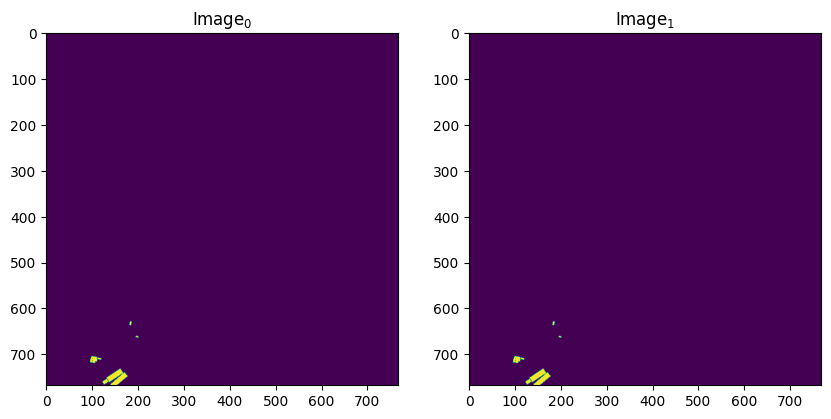

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = lables.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = combine_masks(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_mask_encoder(img_0)
img_1 = combine_masks(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
121698,a1d2a4259.jpg,0,0.0,[0.0],210.943359
171178,e3a87cfcd.jpg,0,0.0,[0.0],263.076172
76018,651226ad8.jpg,0,0.0,[0.0],170.932617
46846,3e7ba0cc5.jpg,0,0.0,[0.0],221.904297
4191,059a4215a.jpg,0,0.0,[0.0],245.119141


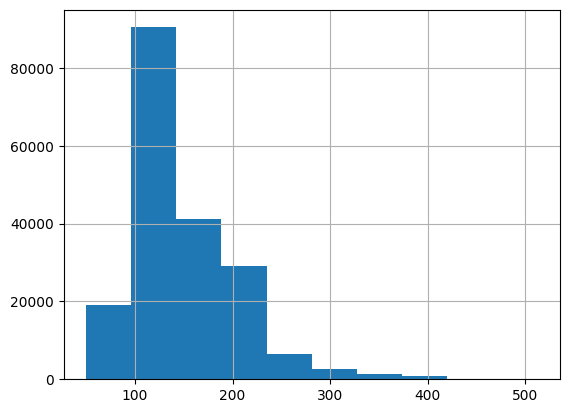

In [50]:
lables['ships'] = lables['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = lables.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)

unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50]
unique_img_ids['file_size_kb'].hist()
lables.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [51]:
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(lables, train_ids)
valid_df = pd.merge(lables, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


<AxesSubplot:>

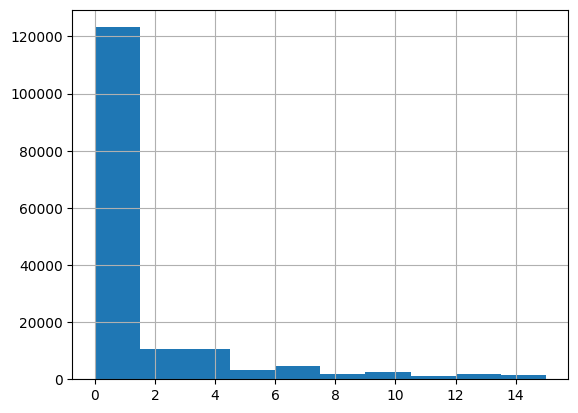

In [52]:
train_df['ships'].hist()

<AxesSubplot:>

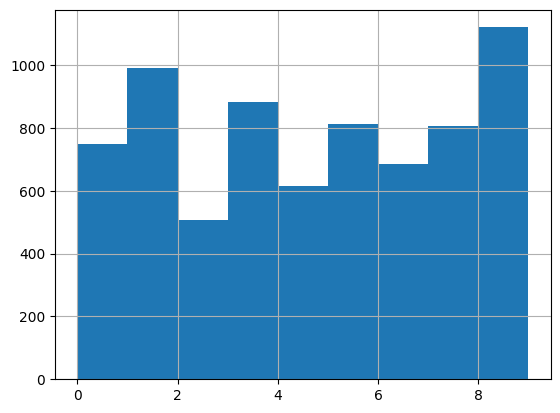

In [59]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//2)
    elif in_df['ships'].values[0]>8:
        return in_df.sample(base_rep_val//2)
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))